In [67]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [68]:
# !cp '/content/drive/MyDrive/spectrograms.zip' .

In [69]:
# !unzip -q spectrograms.zip

In [70]:
# !pip list

In [71]:
# !rm -r /content/logs

In [72]:
import keras.callbacks
import tensorflow as tf
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from tensorflow.keras.utils import Sequence
import math
import pandas as pd
import random
from tensorflow.keras import models, layers, callbacks, activations

import librosa
import librosa.display

import warnings

import pickle

AUTOTUNE = tf.data.AUTOTUNE

# tf.config.run_functions_eagerly(True)

In [73]:
RUN = '1'

SAMPLE_RATE = 24000
FREQ_SIZE = 188
SECONDS = 4

N_MFCC = 100

BATCH_SIZE_TRAIN = 25
BATCH_SIZE_TEST = 1
BATCH_SIZE_VAL = 50
EPOCHS = 100

NUM_TRAIN = 1125
NUM_VAL = 500
NUM_TEST = 250

STEPS_PER_EPOCH = NUM_TRAIN // BATCH_SIZE_TRAIN

NUM_LANGUAGES = 4
LANGUAGES = ['EN','ES','FR','DE']

LOG_DIR = "logs/model" + str(NUM_LANGUAGES) + "-"

SEED = 0
tf.random.set_seed(SEED)
np.random.seed(SEED)

LEARNING_RATE = 0.0001

In [74]:
BASE_DIR_EN = '../../../spectrograms/en/clips/'
TRAIN_PATH_EN = '../../../spectrograms/en/train.tsv'
TEST_PATH_EN = '../../../spectrograms/en/test.tsv'
VAL_PATH_EN = '../../../spectrograms/en/val.tsv'

NUM_TRAIN_EN = NUM_TRAIN
NUM_VAL_EN = NUM_VAL
NUM_TEST_EN = NUM_TEST

LABELS_EN = ['zero','one','two','three','four','five','six','seven','eight','nine','ten','Hey','yes','no','Firefox']
NUM_LABELS_EN = len(LABELS_EN)

In [75]:
BASE_DIR_ES = '../../../spectrograms/es/clips/'
TRAIN_PATH_ES = '../../../spectrograms/es/train3.tsv'
TEST_PATH_ES = '../../../spectrograms/es/test.tsv'
VAL_PATH_ES = '../../../spectrograms/es/val.tsv'

NUM_TRAIN_ES = NUM_TRAIN
NUM_VAL_ES = NUM_VAL
NUM_TEST_ES = NUM_TEST

LABELS_ES = ['cero','cinco','cuatro','dos','Firefox','Hey','no','neuve','ocho','seis','siete','tres','uno','sí']
NUM_LABELS_ES = len(LABELS_ES)

In [76]:
BASE_DIR_FR = '../../../spectrograms/fr/clips/'
TRAIN_PATH_FR = '../../../spectrograms/fr/train3.tsv'
TEST_PATH_FR = '../../../spectrograms/fr/test.tsv'
VAL_PATH_FR = '../../../spectrograms/fr/val.tsv'

NUM_TRAIN_FR = NUM_TRAIN
NUM_VAL_FR = NUM_VAL
NUM_TEST_FR = NUM_TEST

LABELS_FR = ['zéro','un','deux','trois','quatre','cinq','six','sept','huit','neuf','dix','Hey','oui','non','Firefox']
NUM_LABELS_FR = len(LABELS_FR)

In [77]:
BASE_DIR_DE = '../../../spectrograms/de/clips/'
TRAIN_PATH_DE = '../../../spectrograms/de/train3.tsv'
TEST_PATH_DE = '../../../spectrograms/de/test.tsv'
VAL_PATH_DE = '../../../spectrograms/de/val.tsv'

NUM_TRAIN_DE = NUM_TRAIN
NUM_VAL_DE = NUM_VAL
NUM_TEST_DE = NUM_TEST

LABELS_DE = ['zwei','vier','sieben','sechs','neun','nein','nan','ja','fünf','eins','drei','acht','Hey','Hei','Firefox']
NUM_LABELS_DE = len(LABELS_DE)

In [78]:
def padaudio(waveform):
    if (len(waveform) >= SAMPLE_RATE * SECONDS):
        return waveform
    else:
        return np.pad(waveform,(0,SAMPLE_RATE * SECONDS - len(waveform)),mode='constant', constant_values=(0,0))

# def processdata(file):
#     waveform,sample_rate = librosa.load(file, SAMPLE_RATE)
#     waveform = padaudio(waveform)
#     mfccs = librosa.feature.mfcc(waveform,sr=sample_rate,n_mfcc=N_MFCC)
#     mfccs = np.moveaxis(mfccs,1,0)
#     scaler = StandardScaler()
#     mfccs_scaled = scaler.fit_transform(mfccs)
#     return mfccs_scaled.reshape(mfccs_scaled.shape[0], mfccs_scaled.shape[1],1)

def processdata(file):
    # print(file)
    filename = '../../..' + file.split(".")[-2] + '.pkl'
    # print(filename)
    with open(filename,'rb') as f:
        spectrogram = pickle.load(f)
    return spectrogram

In [79]:
def getlabel(onehot,labels):
    index = np.argmax(onehot)
    label = labels[index]
    return label

def getonehot(label,labels):
    onehot = np.array([1 if x == label else 0 for x in labels])
    return onehot

In [80]:
def getdata(df,base_dir):
    df['fullpath'] = base_dir + df['path']
    inputs = df['fullpath'].tolist()
    labels = df['sentence'].tolist()
    x = np.array(inputs)
    y = np.array(labels)
    return x,y

In [81]:
dftrainEN = pd.read_csv(TRAIN_PATH_EN, sep='\t', header=0)
dftrainEN.sort_values(by='length',ascending=False,inplace=True)
trainxEN,trainyEN, = getdata(dftrainEN.head(NUM_TRAIN_EN), BASE_DIR_EN)

dfvalEN = pd.read_csv(VAL_PATH_EN, sep='\t', header=0)
dfvalEN.sort_values(by='length',ascending=False,inplace=True)
valxEN,valyEN, = getdata(dfvalEN.head(NUM_VAL_EN), BASE_DIR_EN)

dftestEN = pd.read_csv(TEST_PATH_EN, sep='\t', header=0)
dftestEN.sort_values(by='length',ascending=False,inplace=True)
testxEN,testyEN, = getdata(dftestEN.head(NUM_TEST_EN), BASE_DIR_EN)

C:\Users\aning\AppData\Local\Temp/ipykernel_8592/954889505.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fullpath'] = base_dir + df['path']


In [82]:
dftrainES = pd.read_csv(TRAIN_PATH_ES, sep='\t', header=0)
dftrainES.sort_values(by='length',ascending=False,inplace=True)
trainxES,trainyES, = getdata(dftrainES.head(NUM_TRAIN_ES), BASE_DIR_ES)

dfvalES = pd.read_csv(VAL_PATH_ES, sep='\t', header=0)
dfvalES.sort_values(by='length',ascending=False,inplace=True)
valxES,valyES, = getdata(dfvalES.head(NUM_VAL_ES), BASE_DIR_ES)

dftestES = pd.read_csv(TEST_PATH_ES, sep='\t', header=0)
dftestES.sort_values(by='length',ascending=False,inplace=True)
testxES,testyES, = getdata(dftestES.head(NUM_TEST_ES), BASE_DIR_ES)

C:\Users\aning\AppData\Local\Temp/ipykernel_8592/954889505.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fullpath'] = base_dir + df['path']


In [83]:
dftrainFR = pd.read_csv(TRAIN_PATH_FR, sep='\t', header=0)
dftrainFR.sort_values(by='length',ascending=False,inplace=True)
trainxFR,trainyFR, = getdata(dftrainFR.head(NUM_TRAIN_FR), BASE_DIR_FR)

dfvalFR = pd.read_csv(VAL_PATH_FR, sep='\t', header=0)
dfvalFR.sort_values(by='length',ascending=False,inplace=True)
valxFR,valyFR, = getdata(dfvalFR.head(NUM_VAL_FR), BASE_DIR_FR)

dftestFR = pd.read_csv(TEST_PATH_FR, sep='\t', header=0)
dftestFR.sort_values(by='length',ascending=False,inplace=True)
testxFR,testyFR, = getdata(dftestFR.head(NUM_TEST_FR), BASE_DIR_FR)

C:\Users\aning\AppData\Local\Temp/ipykernel_8592/954889505.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fullpath'] = base_dir + df['path']


In [84]:
dftrainDE = pd.read_csv(TRAIN_PATH_DE, sep='\t', header=0)
dftrainDE.sort_values(by='length',ascending=False,inplace=True)
trainxDE,trainyDE, = getdata(dftrainDE.head(NUM_TRAIN_DE), BASE_DIR_DE)

dfvalDE = pd.read_csv(VAL_PATH_DE, sep='\t', header=0)
dfvalDE.sort_values(by='length',ascending=False,inplace=True)
valxDE,valyDE, = getdata(dfvalDE.head(NUM_VAL_DE), BASE_DIR_DE)

dftestDE = pd.read_csv(TEST_PATH_DE, sep='\t', header=0)
dftestDE.sort_values(by='length',ascending=False,inplace=True)
testxDE,testyDE, = getdata(dftestDE.head(NUM_TEST_DE), BASE_DIR_DE)

C:\Users\aning\AppData\Local\Temp/ipykernel_8592/954889505.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['fullpath'] = base_dir + df['path']


In [85]:
# print(trainxEN)
# processdata(trainxEN[0])

In [86]:
def maketraingenerator(trainxs, trainys):
    def traingenerator():
        for i in range(len(trainxEN)):
            xs = []
            ys = []

            for trainx,trainy in zip(trainxs,trainys):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    xs.append(processdata(trainx[i]))
                ys.append(getonehot(trainy[0][i],trainy[1]))

            xst = tuple(xs)
            yst = tuple(ys)
            yield xst,yst
    return traingenerator


xtypes = tuple([tf.float32]*NUM_LANGUAGES)
ytypes = tuple([tf.int32]*NUM_LANGUAGES)
traingentypes = (xtypes,ytypes)

xshapes = tuple([[FREQ_SIZE,N_MFCC,1] for i in range(NUM_LANGUAGES)])
yshapes = tuple([[15],[14],[15],[15]])
traingenshapes = (xshapes,yshapes)

In [87]:
def makevalgenerator(trainxs, trainys):
    def traingenerator():
        for i in range(len(valxEN)):
            xs = []
            ys = []

            for trainx,trainy in zip(trainxs,trainys):
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore")
                    xs.append(processdata(trainx[i]))
                ys.append(getonehot(trainy[0][i],trainy[1]))

            xst = tuple(xs)
            yst = tuple(ys)
            yield xst,yst
    return traingenerator

In [88]:
trainxs = [trainxEN,trainxES,trainxFR,trainxDE]
trainys = [[trainyEN,LABELS_EN],[trainyES,LABELS_ES],[trainyFR,LABELS_FR],[trainyDE,LABELS_DE]]

valxs = [valxEN,valxES,valxFR,valxDE]
valys = [[valyEN,LABELS_EN],[valyES,LABELS_ES],[valyFR,LABELS_FR],[valyDE,LABELS_DE]]

In [89]:
def maketestgenerator(testx,testy,labels):
    def testgenerator():
        for i in range(len(testx)):
            x = processdata(testx[i])
            y = getonehot(testy[i],labels)
            yield x,y
    return testgenerator

testgentypes = (tf.float32,tf.int32)
testgenshapes = ([FREQ_SIZE,N_MFCC,1],[15])

In [90]:
traindataset = tf.data.Dataset.from_generator(maketraingenerator(trainxs,trainys),output_types=traingentypes,output_shapes=traingenshapes)
traindataset = traindataset.shuffle(NUM_TRAIN_EN)
traindataset = traindataset.batch(BATCH_SIZE_TRAIN)
traindataset = traindataset.repeat(-1)
traindataset = traindataset.cache().prefetch(AUTOTUNE)

valdataset = tf.data.Dataset.from_generator(makevalgenerator(valxs,valys),output_types=traingentypes,output_shapes=traingenshapes)
valdataset = valdataset.batch(BATCH_SIZE_VAL)
valdataset = valdataset.cache().prefetch(AUTOTUNE)

testdatasetEN = tf.data.Dataset.from_generator(maketestgenerator(testxEN,testyEN,LABELS_EN),output_types=testgentypes,output_shapes=testgenshapes)
testdatasetEN = testdatasetEN.batch(BATCH_SIZE_TEST)

testdatasetES = tf.data.Dataset.from_generator(maketestgenerator(testxES,testyES,LABELS_ES),output_types=testgentypes,output_shapes=([FREQ_SIZE,N_MFCC,1],[14]))
testdatasetES = testdatasetES.batch(BATCH_SIZE_TEST)

testdatasetFR = tf.data.Dataset.from_generator(maketestgenerator(testxFR,testyFR,LABELS_FR),output_types=testgentypes,output_shapes=testgenshapes)
testdatasetFR = testdatasetFR.batch(BATCH_SIZE_TEST)

testdatasetDE = tf.data.Dataset.from_generator(maketestgenerator(testxDE,testyDE,LABELS_DE),output_types=testgentypes,output_shapes=testgenshapes)
testdatasetDE = testdatasetDE.batch(BATCH_SIZE_TEST)

In [91]:
# print(trainxs)

In [92]:
# traingen = maketraingenerator(trainxs,trainys)
# print(next(traingen()))

# print(traingentypes)
# print(traingenshapes)

In [93]:
def languagelayers(num_labels,language):
        lang = keras.Sequential([
        layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation=activations.relu, name=language+'_Conv2D1'),
        layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), name=language+'_MaxPool2D1'),
        # layers.Conv2D(filters=512, kernel_size=(2,2), strides=(1,1), padding='same', activation=activations.relu, name=language+'_Conv2D2'),
        # layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), name=language+'_MaxPool2D2'),
        layers.Flatten(),
        layers.Dropout(0.2),
        layers.Dense(128, activation=activations.relu, name=language+'_DenseLayer1'),
        layers.Dropout(0.2),
        layers.Dense(128, activation=activations.relu, name=language+'_DenseLayer2'),
        layers.Dropout(0.2),
        layers.Dense(num_labels, activation=activations.softmax, name=language+'_Output')
        ],
        name=language)

        return lang

Model: "Full_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 EN_Input (InputLayer)          [(None, 188, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 ES_Input (InputLayer)          [(None, 188, 100, 1  0           []                               
                                )]                                                                
                                                                                                  
 FR_Input (InputLayer)          [(None, 188, 100, 1  0           []                               
                                )]                                                       

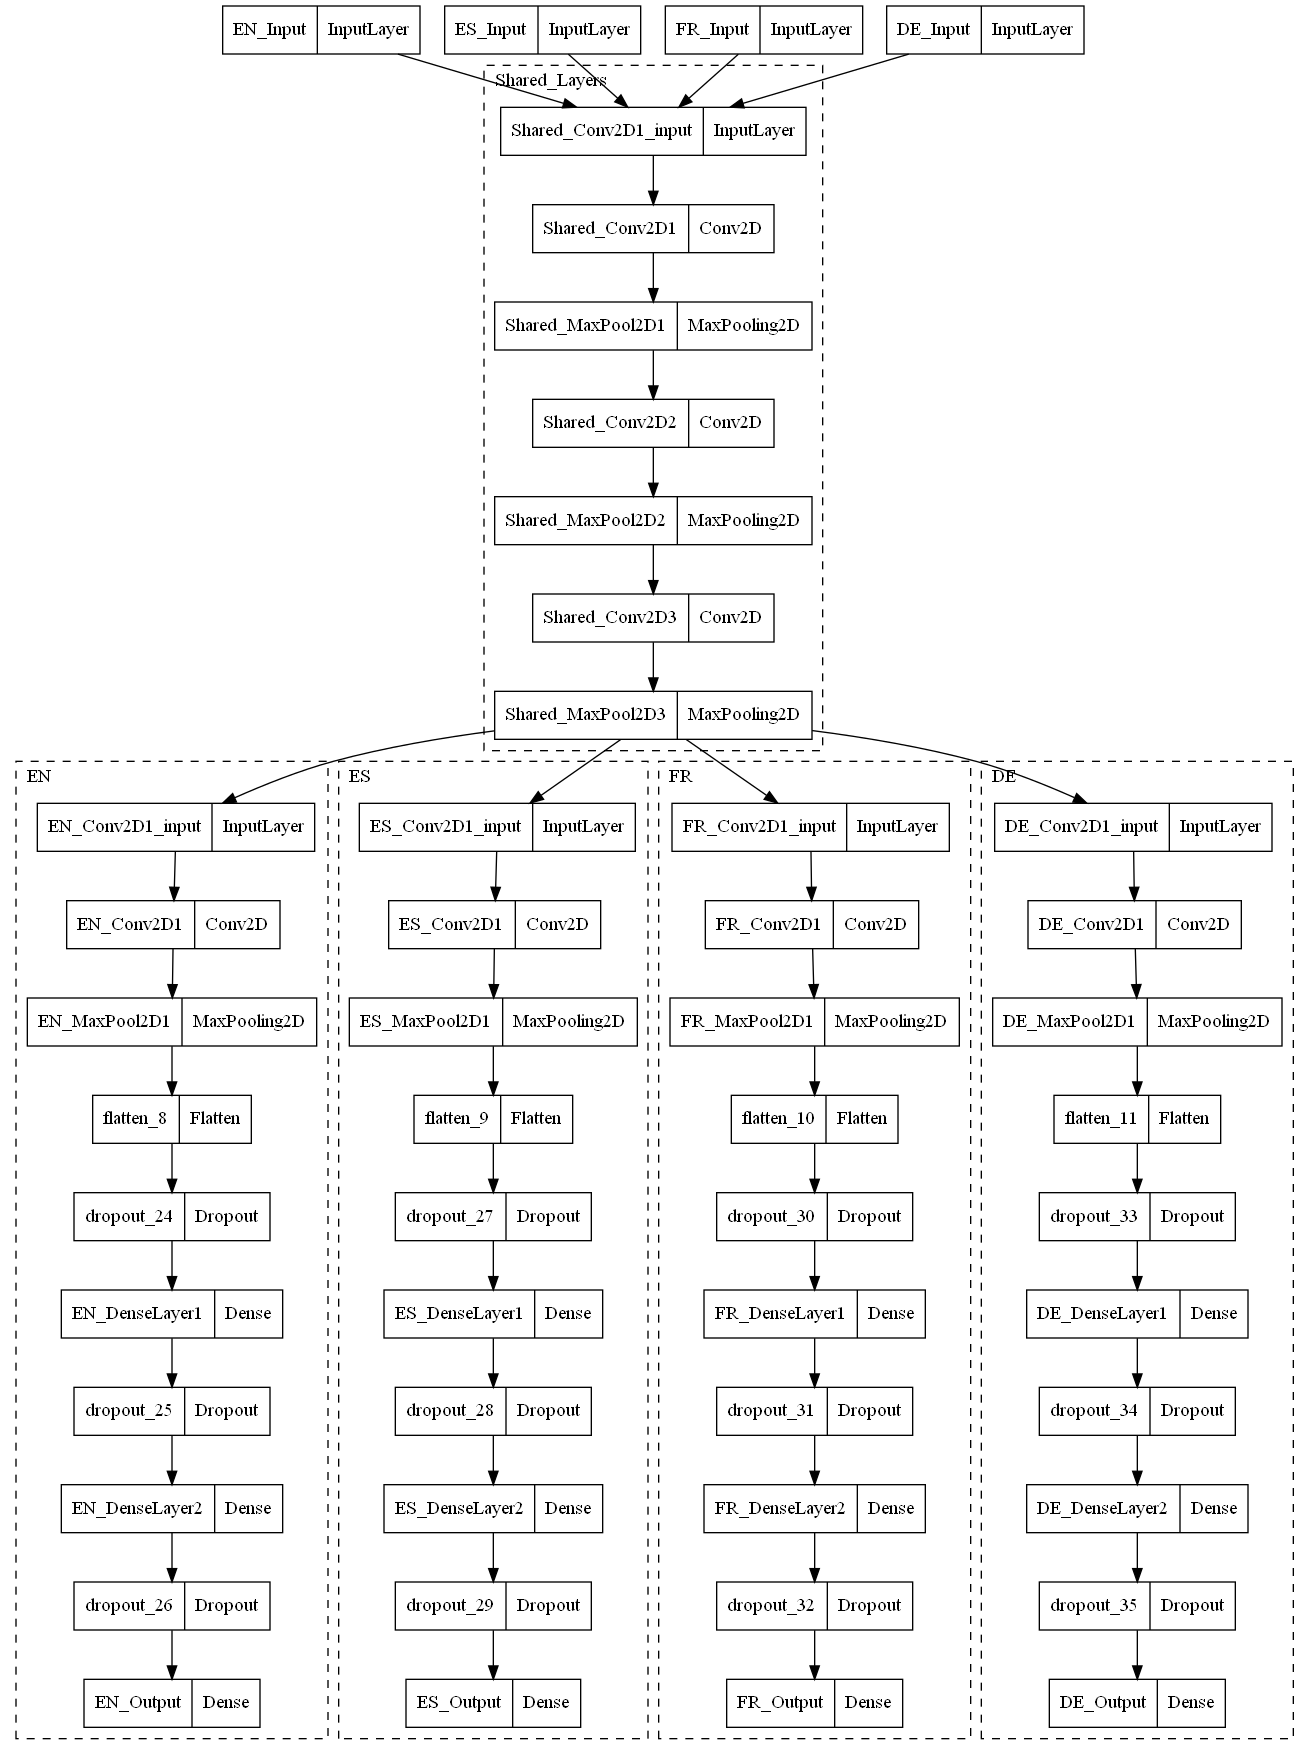

In [94]:
inputEN = tf.keras.Input(shape=(FREQ_SIZE,N_MFCC,1),name='EN_Input')
inputES = tf.keras.Input(shape=(FREQ_SIZE,N_MFCC,1),name='ES_Input')
inputFR = tf.keras.Input(shape=(FREQ_SIZE,N_MFCC,1),name='FR_Input')
inputDE = tf.keras.Input(shape=(FREQ_SIZE,N_MFCC,1),name='DE_Input')

shared = keras.Sequential([
    layers.Conv2D(filters=32, kernel_size=(9,9), strides=(2,2), padding='same', activation=activations.relu, name='Shared_Conv2D1'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), name='Shared_MaxPool2D1'),
    layers.Conv2D(filters=64, kernel_size=(5,5), strides=(1,1), padding='same', activation=activations.relu, name='Shared_Conv2D2'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), name='Shared_MaxPool2D2'),
    layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation=activations.relu, name='Shared_Conv2D3'),
    layers.MaxPooling2D(pool_size=(3,3), strides=(2,2), name='Shared_MaxPool2D3'),
    # layers.Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation=activations.relu, name='Shared_Conv2D4'),
    # layers.MaxPooling2D(pool_size=(2,2), strides=(2,2), name='Shared_MaxPool2D4'),
    ],
    name='Shared_Layers'
)

sharedLayersEN = shared(inputEN)
sharedLayersES = shared(inputES)
sharedLayersFR = shared(inputFR)
sharedLayersDE = shared(inputDE)

layersEN = languagelayers(NUM_LABELS_EN,'EN')(sharedLayersEN)
layersES = languagelayers(NUM_LABELS_ES,'ES')(sharedLayersES)
layersFR = languagelayers(NUM_LABELS_FR,'FR')(sharedLayersFR)
layersDE = languagelayers(NUM_LABELS_DE,'DE')(sharedLayersDE)

model = tf.keras.Model(
    inputs=[inputEN,inputES,inputFR,inputDE],
    outputs=[layersEN,layersES,layersFR,layersDE],
    name='Full_Model'
)


model.summary(expand_nested=True)
tf.keras.utils.plot_model(model, expand_nested=True)

In [95]:
model.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=[tf.keras.losses.CategoricalCrossentropy(),tf.keras.losses.CategoricalCrossentropy(),tf.keras.losses.CategoricalCrossentropy(),tf.keras.losses.CategoricalCrossentropy()],
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical_Accuracy'), tf.keras.metrics.AUC(name='AUC')]
)

In [96]:
training_callback = callbacks.TensorBoard(log_dir=LOG_DIR + RUN)
reduce_lr_callback = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2,min_lr=1e-5,verbose=1)
earlystopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [97]:
# model.predict(testdatasetEN)

In [98]:
history = model.fit(
    x = traindataset,
    validation_data = valdataset,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callback,earlystopping_callback,reduce_lr_callback],
    verbose=1
)


Epoch 1/100
45/45 [==============================] - 53s 752ms/step - loss: 10.5310 - EN_loss: 2.6996 - ES_loss: 2.4140 - FR_loss: 2.7060 - DE_loss: 2.7114 - EN_Categorical_Accuracy: 0.0729 - EN_AUC: 0.5391 - ES_Categorical_Accuracy: 0.1076 - ES_AUC: 0.5486 - FR_Categorical_Accuracy: 0.0711 - FR_AUC: 0.5250 - DE_Categorical_Accuracy: 0.0738 - DE_AUC: 0.5266 - val_loss: 10.4542 - val_EN_loss: 2.6779 - val_ES_loss: 2.4229 - val_FR_loss: 2.6806 - val_DE_loss: 2.6727 - val_EN_Categorical_Accuracy: 0.1060 - val_EN_AUC: 0.5560 - val_ES_Categorical_Accuracy: 0.0880 - val_ES_AUC: 0.5517 - val_FR_Categorical_Accuracy: 0.0760 - val_FR_AUC: 0.5379 - val_DE_Categorical_Accuracy: 0.0760 - val_DE_AUC: 0.5858 - lr: 1.0000e-04

In [99]:
modelEN = tf.keras.Model(
    inputs=inputEN,
    outputs=layersEN,
    name='ENModel'
)

modelEN.compile(optimizer = tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical Accuracy'),tf.keras.metrics.AUC(name='AUC')])

modelEN.evaluate(testdatasetEN)

250/250 [==============================] - 10s 9ms/step - loss: 1.5915 - Categorical Accuracy: 0.5000 - AUC: 0.9059

[1.59148108959198, 0.5, 0.9059406518936157]

In [100]:
modelES = tf.keras.Model(
    inputs=inputES,
    outputs=layersES,
    name='ESModel'
)

modelES.compile(optimizer = tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical Accuracy'),tf.keras.metrics.AUC(name='AUC')])

modelES.evaluate(testdatasetES)

250/250 [==============================] - 2s 9ms/step - loss: 1.7503 - Categorical Accuracy: 0.4320 - AUC: 0.8849

[1.7502577304840088, 0.4320000112056732, 0.8849204778671265]

In [101]:
modelFR = tf.keras.Model(
    inputs=inputFR,
    outputs=layersFR,
    name='FRModel'
)

modelFR.compile(optimizer = tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical Accuracy'),tf.keras.metrics.AUC(name='AUC')])

modelFR.evaluate(testdatasetFR)

250/250 [==============================] - 3s 9ms/step - loss: 1.4865 - Categorical Accuracy: 0.4960 - AUC: 0.9181

[1.4865190982818604, 0.4959999918937683, 0.9180890321731567]

In [102]:
modelDE = tf.keras.Model(
    inputs=inputDE,
    outputs=layersDE,
    name='DEModel'
)

modelDE.compile(optimizer = tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical Accuracy'),tf.keras.metrics.AUC(name='AUC')])

modelDE.evaluate(testdatasetDE)

250/250 [==============================] - 3s 11ms/step - loss: 1.7437 - Categorical Accuracy: 0.4760 - AUC: 0.8815

[1.7437236309051514, 0.47600001096725464, 0.8814605474472046]

In [134]:
# model.save('savedmodels/model3' + RUN)
# shared.save('savedmodels/model31-Shared')

INFO:tensorflow:Assets written to: savedmodels/model31-Shared\assets


INFO:tensorflow:Assets written to: savedmodels/model31-Shared\assets


In [104]:
# modelsave = keras.models.load_model('savedmodels/model22')
#
# model.summary()

In [105]:
shared.trainable = False

In [106]:
newSharedLayersEN = shared(inputEN)
newLayersEN = languagelayers(NUM_LABELS_EN,'EN')(newSharedLayersEN)

In [107]:
modelENRetrain = tf.keras.Model(
    inputs=inputEN,
    outputs=newLayersEN,
    name='ENModelRetrain'
)

Model: "ENModelRetrain"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 EN_Input (InputLayer)       [(None, 188, 100, 1)]     0         
                                                                 
 Shared_Layers (Sequential)  (None, 10, 5, 128)        127744    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Shared_Conv2D1 (Conv2D)   (None, 94, 50, 32)        2624      |
|                                                               |
| Shared_MaxPool2D1 (MaxPooli  (None, 46, 24, 32)     0         |
| ng2D)                                                         |
|                                                               |
| Shared_Conv2D2 (Conv2D)   (None, 46, 24, 64)        51264     |
|                                                               |
| Shared_MaxPool2D2 (MaxPooli  (None, 22, 11, 64)     0         |
| ng2D)                                             

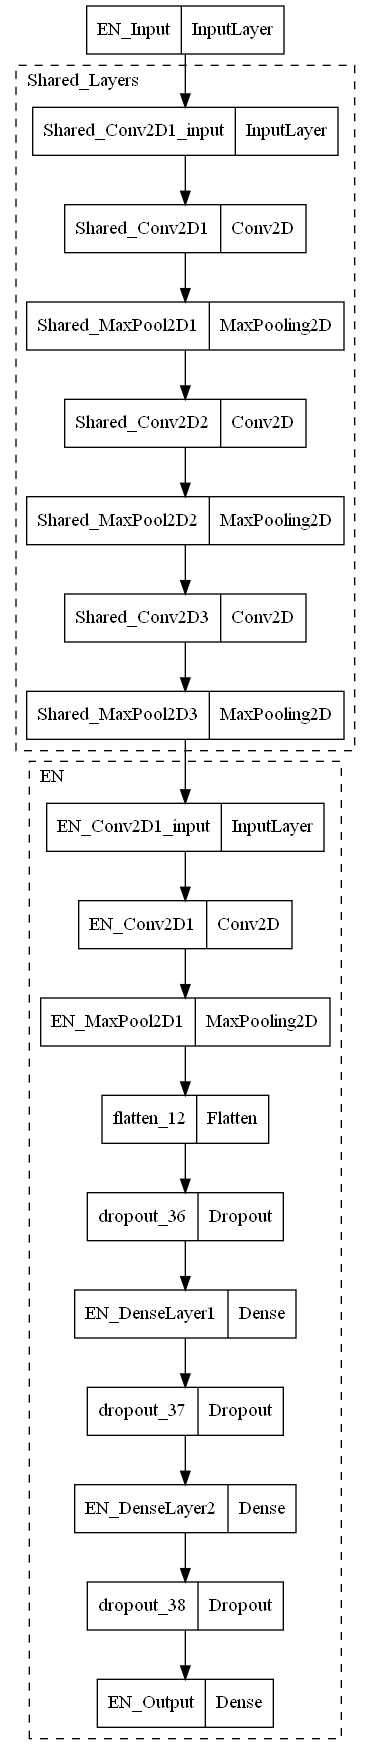

In [108]:
modelENRetrain.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical Accuracy'),tf.keras.metrics.AUC(name='AUC')]
)

modelENRetrain.summary(expand_nested=True)
tf.keras.utils.plot_model(modelENRetrain, expand_nested=True)

In [109]:
trainxENs = [trainxEN]
trainyENs = [[trainyEN,LABELS_EN]]

valxENs = [valxEN]
valyENs = [[valyEN,LABELS_EN]]

xtypes = tuple([tf.float32]*1)
ytypes = tuple([tf.int32]*1)
traingentypes = (xtypes,ytypes)

xshapes = tuple([[FREQ_SIZE,N_MFCC,1] for i in range(1)])
yshapes = tuple([[15]])
traingenshapes = (xshapes,yshapes)

traindatasetEN = tf.data.Dataset.from_generator(maketraingenerator(trainxENs,trainyENs),output_types=traingentypes,output_shapes=traingenshapes)
traindatasetEN = traindatasetEN.shuffle(NUM_TRAIN_EN)
traindatasetEN = traindatasetEN.batch(BATCH_SIZE_TRAIN)
traindatasetEN = traindatasetEN.repeat(-1)
traindatasetEN = traindatasetEN.cache().prefetch(AUTOTUNE)

valdatasetEN = tf.data.Dataset.from_generator(makevalgenerator(valxENs,valyENs),output_types=traingentypes,output_shapes=traingenshapes)
valdatasetEN = valdatasetEN.batch(BATCH_SIZE_VAL)
valdatasetEN = valdatasetEN.cache().prefetch(AUTOTUNE)

In [110]:
training_callbackEN = callbacks.TensorBoard(log_dir=LOG_DIR + RUN + '-Retrain-EN')

historyEN = modelENRetrain.fit(
    x = traindatasetEN,
    validation_data = valdatasetEN,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callbackEN,earlystopping_callback,reduce_lr_callback],
    verbose=1
)

Epoch 1/100
45/45 [==============================] - 7s 102ms/step - loss: 2.8218 - Categorical Accuracy: 0.0924 - AUC: 0.5722 - val_loss: 2.5217 - val_Categorical Accuracy: 0.1760 - val_AUC: 0.6912 - lr: 1.0000e-04

In [111]:
modelENRetrain.evaluate(testdatasetEN)

250/250 [==============================] - 4s 9ms/step - loss: 1.3918 - Categorical Accuracy: 0.5200 - AUC: 0.9262

[1.3917778730392456, 0.5199999809265137, 0.9262380599975586]

In [112]:
# modelENRetrain.save('savedmodels/model-EN-Retrain')

In [113]:
newSharedLayersES = shared(inputES)
newLayersES = languagelayers(NUM_LABELS_ES,'ES')(newSharedLayersES)

In [114]:
modelESRetrain = tf.keras.Model(
    inputs=inputES,
    outputs=newLayersES,
    name='ESModelRetrain'
)

Model: "ESModelRetrain"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 ES_Input (InputLayer)       [(None, 188, 100, 1)]     0         
                                                                 
 Shared_Layers (Sequential)  (None, 10, 5, 128)        127744    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Shared_Conv2D1 (Conv2D)   (None, 94, 50, 32)        2624      |
|                                                               |
| Shared_MaxPool2D1 (MaxPooli  (None, 46, 24, 32)     0         |
| ng2D)                                                         |
|                                                               |
| Shared_Conv2D2 (Conv2D)   (None, 46, 24, 64)        51264     |
|                                                               |
| Shared_MaxPool2D2 (MaxPooli  (None, 22, 11, 64)     0         |
| ng2D)                                             

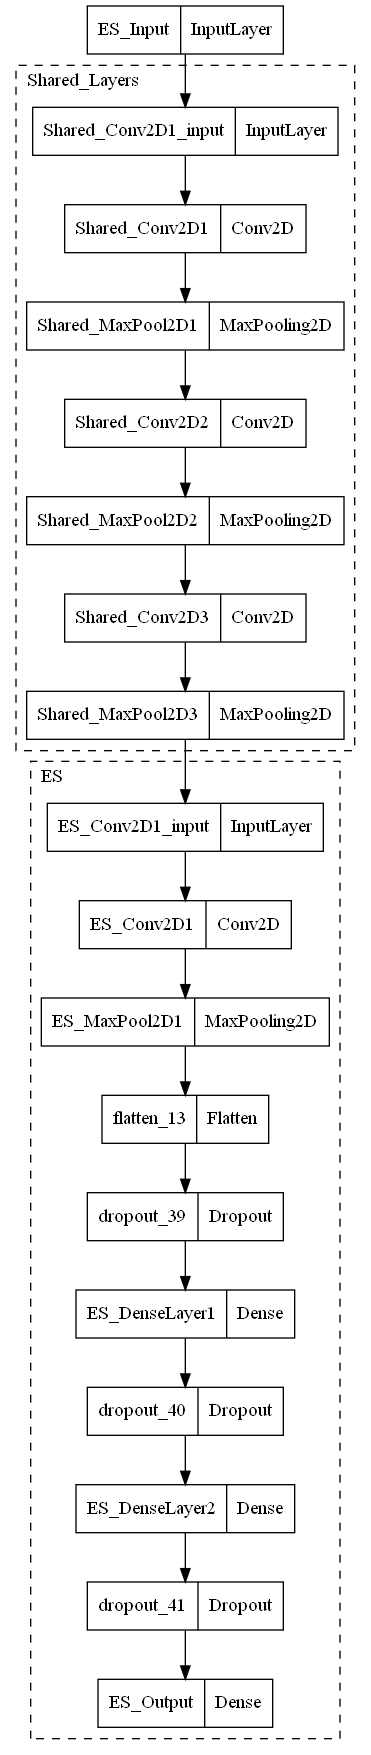

In [115]:
modelESRetrain.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical Accuracy'),tf.keras.metrics.AUC(name='AUC')]
)

modelESRetrain.summary(expand_nested=True)
tf.keras.utils.plot_model(modelESRetrain, expand_nested=True)

In [116]:
trainxESs = [trainxES]
trainyESs = [[trainyES,LABELS_ES]]

valxESs = [valxES]
valyESs = [[valyES,LABELS_ES]]

xtypes = tuple([tf.float32]*1)
ytypes = tuple([tf.int32]*1)
traingentypes = (xtypes,ytypes)

xshapes = tuple([[FREQ_SIZE,N_MFCC,1] for i in range(1)])
yshapes = tuple([[14]])
traingenshapes = (xshapes,yshapes)

traindatasetES = tf.data.Dataset.from_generator(maketraingenerator(trainxESs,trainyESs),output_types=traingentypes,output_shapes=traingenshapes)
traindatasetES = traindatasetES.shuffle(NUM_TRAIN_ES)
traindatasetES = traindatasetES.batch(BATCH_SIZE_TRAIN)
traindatasetES = traindatasetES.repeat(-1)
traindatasetES = traindatasetES.cache().prefetch(AUTOTUNE)

valdatasetES = tf.data.Dataset.from_generator(makevalgenerator(valxESs,valyESs),output_types=traingentypes,output_shapes=traingenshapes)
valdatasetES = valdatasetES.batch(BATCH_SIZE_VAL)
valdatasetES = valdatasetES.cache().prefetch(AUTOTUNE)

In [117]:
training_callbackES = callbacks.TensorBoard(log_dir=LOG_DIR + RUN + '-Retrain-ES')

historyES = modelESRetrain.fit(
    x = traindatasetES,
    validation_data = valdatasetES,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callbackES,earlystopping_callback,reduce_lr_callback],
    verbose=1
)

Epoch 1/100
45/45 [==============================] - 5s 73ms/step - loss: 2.5235 - Categorical Accuracy: 0.0880 - AUC: 0.5536 - val_loss: 2.3461 - val_Categorical Accuracy: 0.1440 - val_AUC: 0.6367 - lr: 1.0000e-04

In [118]:
modelESRetrain.evaluate(testdatasetES)

250/250 [==============================] - 2s 7ms/step - loss: 1.2893 - Categorical Accuracy: 0.5080 - AUC: 0.9247

[1.2893459796905518, 0.5080000162124634, 0.9247469902038574]

In [119]:
# modelESRetrain.save('savedmodels/model-ES-Retrain')

In [120]:
newSharedLayersFR = shared(inputFR)
newLayersFR = languagelayers(NUM_LABELS_FR,'FR')(newSharedLayersFR)

In [121]:
modelFRRetrain = tf.keras.Model(
    inputs=inputFR,
    outputs=newLayersFR,
    name='FRModelRetrain'
)

Model: "FRModelRetrain"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 FR_Input (InputLayer)       [(None, 188, 100, 1)]     0         
                                                                 
 Shared_Layers (Sequential)  (None, 10, 5, 128)        127744    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Shared_Conv2D1 (Conv2D)   (None, 94, 50, 32)        2624      |
|                                                               |
| Shared_MaxPool2D1 (MaxPooli  (None, 46, 24, 32)     0         |
| ng2D)                                                         |
|                                                               |
| Shared_Conv2D2 (Conv2D)   (None, 46, 24, 64)        51264     |
|                                                               |
| Shared_MaxPool2D2 (MaxPooli  (None, 22, 11, 64)     0         |
| ng2D)                                             

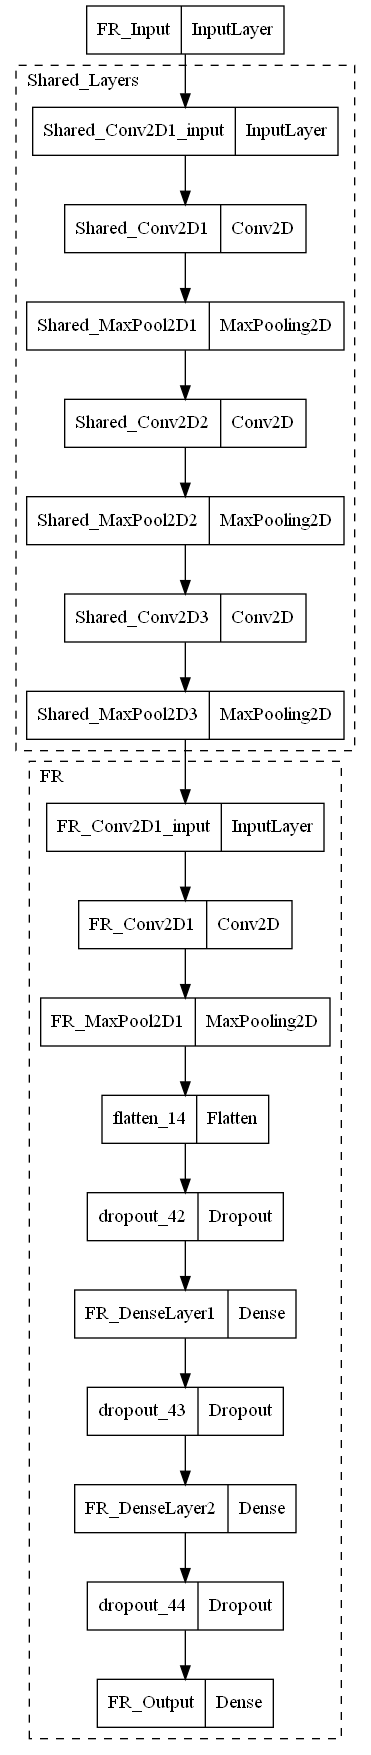

In [122]:
modelFRRetrain.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical Accuracy'),tf.keras.metrics.AUC(name='AUC')]
)

modelFRRetrain.summary(expand_nested=True)
tf.keras.utils.plot_model(modelFRRetrain, expand_nested=True)

In [123]:
trainxFRs = [trainxFR]
trainyFRs = [[trainyFR,LABELS_FR]]

valxFRs = [valxFR]
valyFRs = [[valyFR,LABELS_FR]]

xtypes = tuple([tf.float32]*1)
ytypes = tuple([tf.int32]*1)
traingentypes = (xtypes,ytypes)

xshapes = tuple([[FREQ_SIZE,N_MFCC,1] for i in range(1)])
yshapes = tuple([[15]])
traingenshapes = (xshapes,yshapes)

traindatasetFR = tf.data.Dataset.from_generator(maketraingenerator(trainxFRs,trainyFRs),output_types=traingentypes,output_shapes=traingenshapes)
traindatasetFR = traindatasetFR.shuffle(NUM_TRAIN_ES)
traindatasetFR = traindatasetFR.batch(BATCH_SIZE_TRAIN)
traindatasetFR = traindatasetFR.repeat(-1)
traindatasetFR = traindatasetFR.cache().prefetch(AUTOTUNE)

valdatasetFR = tf.data.Dataset.from_generator(makevalgenerator(valxFRs,valyFRs),output_types=traingentypes,output_shapes=traingenshapes)
valdatasetFR = valdatasetFR.batch(BATCH_SIZE_VAL)
valdatasetFR = valdatasetFR.cache().prefetch(AUTOTUNE)

In [124]:
training_callbackFR = callbacks.TensorBoard(log_dir=LOG_DIR + RUN + '-Retrain-FR')

historyFR = modelFRRetrain.fit(
    x = traindatasetFR,
    validation_data = valdatasetFR,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callbackFR,earlystopping_callback,reduce_lr_callback],
    verbose=1
)

Epoch 1/100
45/45 [==============================] - 5s 71ms/step - loss: 2.8225 - Categorical Accuracy: 0.0951 - AUC: 0.5516 - val_loss: 2.5854 - val_Categorical Accuracy: 0.1080 - val_AUC: 0.6519 - lr: 1.0000e-04

In [125]:
modelFRRetrain.evaluate(testdatasetFR)

250/250 [==============================] - 2s 7ms/step - loss: 1.3464 - Categorical Accuracy: 0.5360 - AUC: 0.9307

[1.3463784456253052, 0.5360000133514404, 0.9306851029396057]

In [126]:
# modelFRRetrain.save('savedmodels/model-FR-Retrain')

In [127]:
newSharedLayersDE = shared(inputDE)
newLayersDE = languagelayers(NUM_LABELS_DE,'DE')(newSharedLayersDE)

In [128]:
modelDERetrain = tf.keras.Model(
    inputs=inputDE,
    outputs=newLayersDE,
    name='DEModelRetrain'
)

Model: "DEModelRetrain"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 DE_Input (InputLayer)       [(None, 188, 100, 1)]     0         
                                                                 
 Shared_Layers (Sequential)  (None, 10, 5, 128)        127744    
|¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯¯|
| Shared_Conv2D1 (Conv2D)   (None, 94, 50, 32)        2624      |
|                                                               |
| Shared_MaxPool2D1 (MaxPooli  (None, 46, 24, 32)     0         |
| ng2D)                                                         |
|                                                               |
| Shared_Conv2D2 (Conv2D)   (None, 46, 24, 64)        51264     |
|                                                               |
| Shared_MaxPool2D2 (MaxPooli  (None, 22, 11, 64)     0         |
| ng2D)                                             

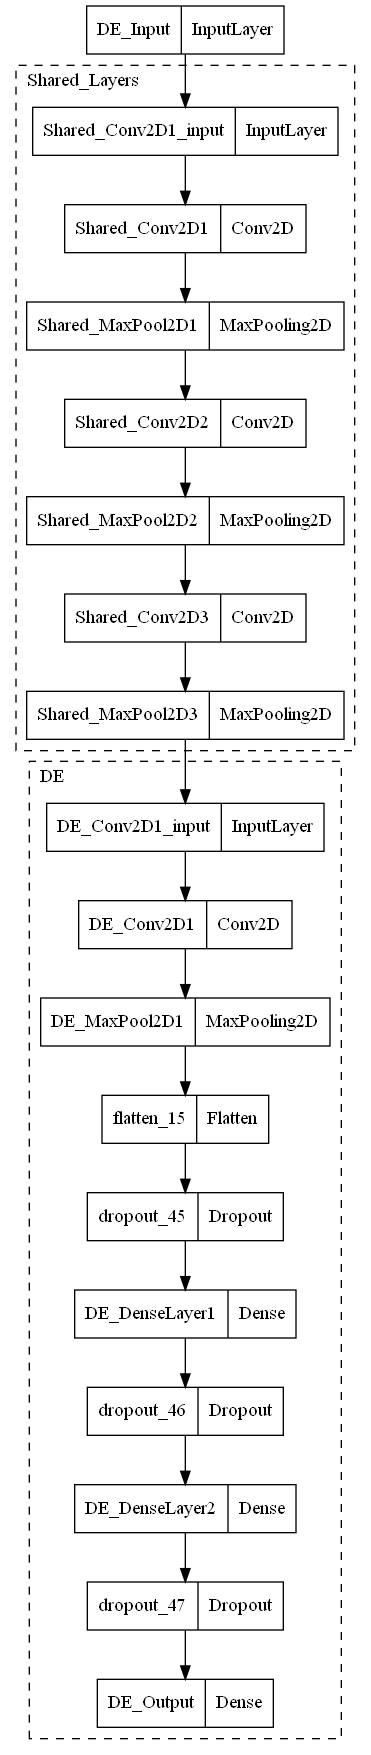

In [129]:
modelDERetrain.compile(
    optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=[tf.keras.metrics.CategoricalAccuracy(name='Categorical Accuracy'),tf.keras.metrics.AUC(name='AUC')]
)

modelDERetrain.summary(expand_nested=True)
tf.keras.utils.plot_model(modelDERetrain, expand_nested=True)

In [130]:
trainxDEs = [trainxDE]
trainyDEs = [[trainyDE,LABELS_DE]]

valxDEs = [valxDE]
valyDEs = [[valyDE,LABELS_DE]]

xtypes = tuple([tf.float32]*1)
ytypes = tuple([tf.int32]*1)
traingentypes = (xtypes,ytypes)

xshapes = tuple([[FREQ_SIZE,N_MFCC,1] for i in range(1)])
yshapes = tuple([[15]])
traingenshapes = (xshapes,yshapes)

traindatasetDE = tf.data.Dataset.from_generator(maketraingenerator(trainxDEs,trainyDEs),output_types=traingentypes,output_shapes=traingenshapes)
traindatasetDE = traindatasetDE.shuffle(NUM_TRAIN_DE)
traindatasetDE = traindatasetDE.batch(BATCH_SIZE_TRAIN)
traindatasetDE = traindatasetDE.repeat(-1)
traindatasetDE = traindatasetDE.cache().prefetch(AUTOTUNE)

valdatasetDE = tf.data.Dataset.from_generator(makevalgenerator(valxDEs,valyDEs),output_types=traingentypes,output_shapes=traingenshapes)
valdatasetDE = valdatasetDE.batch(BATCH_SIZE_VAL)
valdatasetDE = valdatasetDE.cache().prefetch(AUTOTUNE)

In [131]:
training_callbackDE = callbacks.TensorBoard(log_dir=LOG_DIR + RUN + '-Retrain-DE')

historyDE = modelDERetrain.fit(
    x = traindatasetDE,
    validation_data = valdatasetDE,
    epochs=EPOCHS,
    steps_per_epoch=STEPS_PER_EPOCH,
    callbacks=[training_callbackDE,earlystopping_callback,reduce_lr_callback],
    verbose=1
)

Epoch 1/100
45/45 [==============================] - 5s 80ms/step - loss: 2.8547 - Categorical Accuracy: 0.0836 - AUC: 0.5534 - val_loss: 2.6051 - val_Categorical Accuracy: 0.1420 - val_AUC: 0.6456 - lr: 1.0000e-04

In [132]:
modelDERetrain.evaluate(testdatasetDE)

250/250 [==============================] - 3s 8ms/step - loss: 1.6415 - Categorical Accuracy: 0.4320 - AUC: 0.8982

[1.6415120363235474, 0.4320000112056732, 0.8981651067733765]

In [133]:
# modelDERetrain.save('savedmodels/model-DE-Retrain')